# Antenna and Array Demo

In this demo, we illustrate how to use build and simulate antenna elements and arrays.  In going through this demo, you will learn to:

* Load the `mmwchanmod` package
* Construct antenna elements
* Plot the antenna element gain patterns
* Construct antenna arrays from the elements
* Get beamforming vectors for the array
* Plot the array pattern for a given beamforming vector

## Loading the Packages

We first load some standard packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

To access the `mmwchanmod` package, you need to first add the package location to your path and then import it.

In [2]:
path = os.path.abspath('..')
if not path in sys.path:
    sys.path.append(path)
import mmwchanmod as mmc

In this demo, we will use a few of the elements in the `sim` sub-package for simulating systems.

In [3]:
from mmwchanmod.sim.antenna import Elem3GPP
from mmwchanmod.sim.array import URA, RotatedArray
import mmwchanmod.sim.antenna

If you modify the packages, you will need to re-import them.

In [4]:
import imp
imp.reload(mmwchanmod)

<module 'mmwchanmod' (namespace)>

## Creating and Plotting an Antenna Element

We first show how to create an antenna element based on the 3GPP model.  

In the package, the convention for angles are specified as:
* `theta`:  Elevation angle from the x-y plane.  In some routines, `theta` is the inclination angle, the angle from the z axis.
* `phi`:  The azimuth or horizontal angle in the `x-y` plane.

In the 3GPP model, you specify the half-power beamwidths in the azimuth and elevation direction.  By default, the antenna has its boresight (direction for maximum gain) on the `x` axis.

In [5]:
elem = Elem3GPP(thetabw=60, phibw=80)

We can plot the gain of the element as a function of the azimuth angle for a fixed elevation (`theta=0`). We use `nphi=360` points in the azimuth.  This plot is sometimes called an *azimuth cut*.

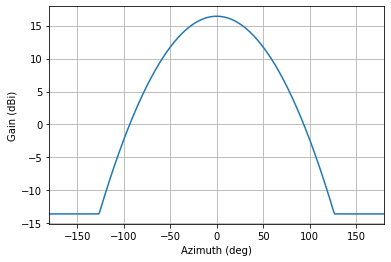

In [6]:
elem.plot_pattern(nphi=360, plot_type='rect_phi')
plt.ylabel('Gain (dBi)')
plt.grid()

Or, we can do a polar plot.  In this case, we two few different elevation cut angles, `theta`. 

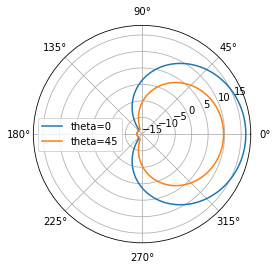

In [7]:
theta = np.array([0,45])
elem.plot_pattern(nphi=360, theta=theta, plot_type='polar_phi')
leg_str = []
for t in theta:
    leg_str.append( 'theta=%d' % t)
plt.legend(leg_str, loc='center left')


Finally, we can also plot the 3D pattern.

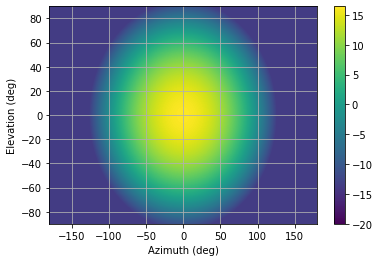

In [8]:
phi, theta, v, ax, im =\
   elem.plot_pattern(nphi=360, ntheta = 180,\
                    plot_type='2d', vmin=-20)
plt.grid()
plt.colorbar(im)

We can also construct antenna elements oriented in different directions.  In this case, we build an antenna pattern oriented off center with much smaller beamwidths.  We can see from the pattern that the peak directivity is higher and located at the desired location.

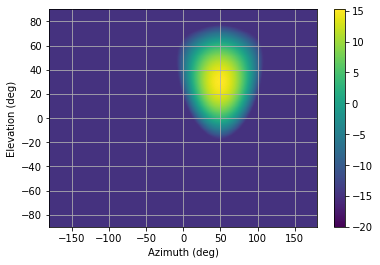

In [9]:
elem = Elem3GPP(theta0=30, phi0=50,thetabw=30, phibw=30)
phi, theta, v, ax, im =\
   elem.plot_pattern(nphi=360, ntheta = 180,\
                    plot_type='2d', vmin=-20)
plt.grid()
plt.colorbar(im)

## Creating an Array 

We next show how to create an uniform rectangular array (URA).  A URA has its elements on the y-z plane so that the direction of maximum gain is in the x-axis.  The following code creates a 3GPP antenna element and then builds an array URA with 8x4 elements.  We then plot the element locations.  By default, the antenna elements are spaced at `lambda/2`, but this can also be changed.

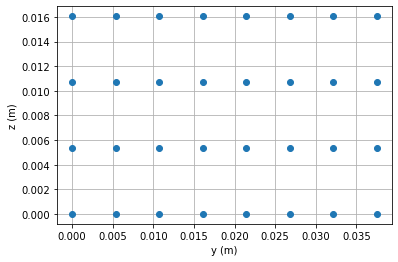

In [10]:
# Antenna element
elem = Elem3GPP(thetabw=90, phibw=80)

# Number of antenna elements in the y and z direction respectively
nant = np.array([8,4])

fc=28e9 # carrier frequency for narrowband response

# Array
arr = URA(elem=elem, nant=nant, fc=fc)

# Plot the antenna positions in the y and z plane
plt.plot(arr.elem_pos[:,1], arr.elem_pos[:,2], 'o')
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.grid()

We can easily get beamforming vectors for specific directions and plot the array pattern for the given beamforming vector.  The following code plots the array pattern with three different directions.  The intended direction is shown in the red dot and we see we can get the maximum gain approximately in that direction.

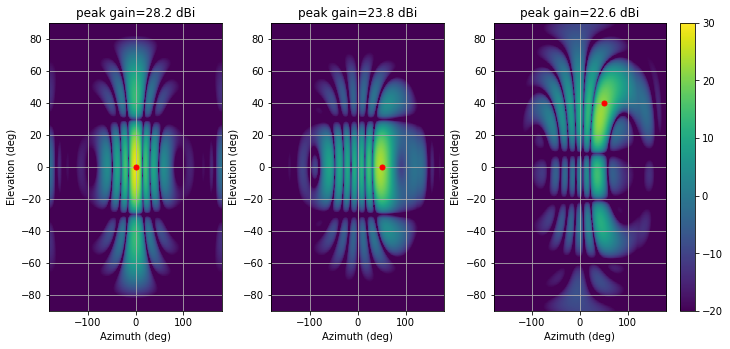

In [11]:
theta0 = [0, 0, 40]
phi0 = [0, 50, 50]
nplot = len(theta0)

fig, ax = plt.subplots(1,nplot, figsize=(10,5))
for i in range(nplot):
    
    # Get the beamform vector
    w = arr.conj_bf(phi0[i], theta0[i])
    
    # Plot the antenna pattern
    # Note the use of passing vmin and vmax, arguments to the plot
    # This makes sure all plots are on the same colorscale
    phi, theta, v, axi, im =\
       arr.plot_pattern(w=w,nphi=360, ntheta = 180,\
                    plot_type='2d', vmin=-20, vmax=30, ax=ax[i])
    axi.grid()
    axi.plot(phi0[i], theta0[i], 'ro', ms=5)
    
    # Compute peak gain
    peak_gain = np.max(v)
    axi.set_title('peak gain=%4.1f dBi' % peak_gain )

# Add a colorbar
plt.tight_layout()
fig.subplots_adjust(bottom=0.1, right=0.93, top=0.9)
cax = plt.axes([0.95, 0.1, 0.02, 0.8])
_ = fig.colorbar(im, cax=cax)   

## Rotating an Array

The array above is constructed to have maximum gain in the x direction.  We can rotate the array using the `RotatedArray` class.  We simply first create the array aligned in the x direction and then pass that to the class along with the desired orientation.  The following code constructs an array oriented in a direction `theta0, phi0` and plots the array pattern with the beam pointed at `theta0, phi0`.

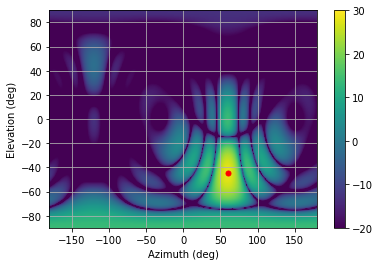

In [12]:
# Desired angle of maximum gain
phi0 = 60
theta0 = -45

# Create the rotated array
arr_rot = RotatedArray(arr,phi0=phi0,theta0=theta0)

# Get BF vector in direction of maximum gain
w = arr_rot.conj_bf(phi0, theta0)

# Get the antenna pattern
phi, theta, v, axi, im =\
   arr_rot.plot_pattern(w=w,nphi=360, ntheta = 180,\
                plot_type='2d', vmin=-20, vmax=30)
axi.grid()
axi.plot(phi0, theta0, 'ro', ms=5)
plt.colorbar(im)

